In [ ]:
#%pip install tensorflow
%pip install seaborn

### Data Collection. 
The dataset includes detailed information on resale transactions of HDB flats between January 1, 2017, and March 30, 2024. The dataset contains 180,154 rows and 11 columns and was downloaded on May 23, 2024. 

**Dataset URL**: [HDB Resale Prices](https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view) 
**HDB RPI URL**:[HDB Resale Prices Index](https://www.hdb.gov.sg/residential/selling-a-flat/overview/resale-statistics)

(180154, 11) (175672, 15) (175672, 52)


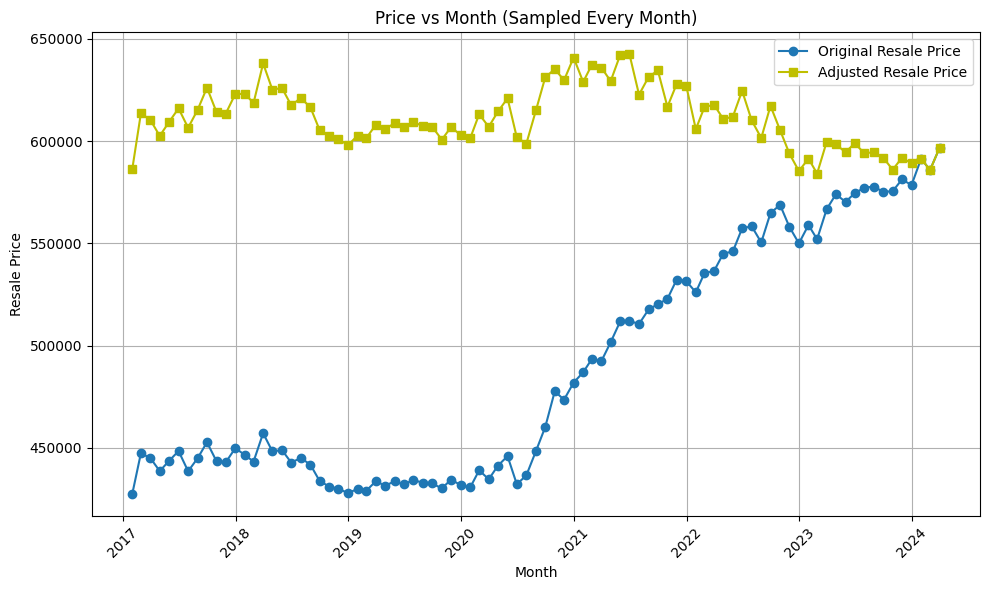

In [2]:
import pandas as pd
import data_config as cfg
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

df_raw = pd.read_csv('./data/SGHDB2017-2024.csv')
cfg.save_dataset_info(df_raw, fname='dataset_info.csv')

df = cfg.adjust_resale_price(df_raw, cut_off_date='2024-04-01')
cfg.visualize_adjusted_price(df[['month', 'resale_price', 'adjusted_price']].copy(), fname='adjusted_price.png')

df_clean = cfg.preprocess_data(df)
print(df_raw.shape, df.shape, df_clean.shape)
df_clean.to_csv('./data/SGHDB2017-2024_clean.csv', index=False)

Install Required Libraries: 
Ensure you have the necessary libraries installed. You can install them using pip if they are not already installed.
```sgh 
pip install tensorflow pandas scikit-learn
```

### Step 1: 
The project starts by importing the pandas library and loading a cleaned CSV file named {SGHDB2017-2024_clean.csv} into a Pandas DataFrame $df$. Then, the {adjusted_price} column, which represents the housing prices to be predicted, is extracted and stored in the variable $y$ and the remaining columns, which serve as features for the model, are stored in the variable $X$.

In [3]:
# Step 1: Load the data
import pandas as pd
df = pd.read_csv('./data/SGHDB2017-2024_clean.csv')
y = df['adjusted_price'].values   # Target
X = df.drop(columns = 'adjusted_price')  # Features

### Step 2: Prepare the Data:
The dataset is well maintained and prepared by the Singapore government's open data portal. There is no missing data, which simplifies the preprocessing steps. 
Load your dataset and prepare it for training. This includes splitting it into training and testing sets and normalizing the features.

In [4]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Step 2: Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize continuous features
continuous_columns = ['flat_type', 'floor_area_sqm',  'floor', 'remaining_lease_months']
binary_columns = df.columns.difference(continuous_columns + ['adjusted_price']).tolist()
scaler = StandardScaler()
X_train_continuous = scaler.fit_transform(X_train[continuous_columns])
X_test_continuous = scaler.transform(X_test[continuous_columns])

# Combine scaled continuous features and binary features
X_train = np.hstack([X_train_continuous, X_train[binary_columns].values])
X_test = np.hstack([X_test_continuous, X_test[binary_columns].values])

### Step 3: 
This step defines a function create_regression_model that constructs a feedforward neural network model for regression using TensorFlow's Keras API. 

In [5]:
import tensorflow as tf

def create_regression_model(input_shape, params={}):
    name='original 3 layers'
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),    
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model,name


In [6]:
X_train.shape

(122970, 51)

### Step 4: 
The model is trained using the training data  (\(X_{\text{train}}\) and \(y_{\text{train}}\)). The training process runs for 10 epochs (def: \ref{def:epoch}) with a batch size of 32. 

In [7]:
# Step 4: Create and train the model
import time
from datetime import timedelta

model,name = create_regression_model(input_shape=[X_train.shape[1]])
start_time = time.time()
history = model.fit(X_train, y_train, epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test),verbose=0)
end_time = time.time()
total_seconds = end_time-start_time
# Convert to hours: minutes:seconds
training_time = str(timedelta(seconds=total_seconds)).split(".")[0]  # Remove microseconds
print(f"Total training time: {training_time}")

Total training time: 0:00:55


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,629 (25.90 KB)

 Trainable params: 2,209 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,420 (17.27 KB)

### Step 5:
In the last step, the model is evaluated using various performance metrics and saves the evaluation results to a CSV file.

In [9]:
# Step 4: Evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

def evaluate_model(model, X_train, y_train, X_test, y_test):

    df_results = pd.DataFrame(columns=['Train', 'Test'])

    y_pred = model.predict(X_train)
    df_results.loc['Root Mean Squared Error', 'Train'] = np.sqrt(mean_squared_error(y_train, y_pred))
    df_results.loc['Mean Aboslute Error', 'Train'] = mean_absolute_error(y_train, y_pred)
    df_results.loc['Mean Aboslute Percentage Error', 'Train'] = mean_absolute_percentage_error(y_train, y_pred)*100
    df_results.loc['R2 score', 'Train'] = r2_score(y_train, y_pred)
    y_pred_train= y_pred.copy()

    y_pred = model.predict(X_test)
    df_results.loc['Root Mean Squared Error', 'Test'] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_results.loc['Mean Aboslute Error', 'Test'] = mean_absolute_error(y_test, y_pred)
    df_results.loc['Mean Aboslute Percentage Error', 'Test'] = mean_absolute_percentage_error(y_test, y_pred)*100
    df_results.loc['R2 score', 'Test'] = r2_score(y_test, y_pred)
    y_pred_test= y_pred.copy()

    df_results = df_results.astype('Float64').round(2)
    return df_results, y_pred_train, y_pred_test


### Visualize part

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(y_actual, y_predicted,title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_predicted, color='blue')
    plt.xlabel('Actual value')
    plt.ylabel('Predicted value')
    plt.title(title)
    plt.show()
def actual_predictions(y_train, y_pred_train, y_test, y_pred_test, subtitle=""):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train, y_pred_train, alpha = 0.3, color='blue', label = "Train")
    plt.scatter(y_test, y_pred_test, alpha = 0.3, color='orange', label= "Test")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{subtitle} Actual Vs Predicted Plot")
    plt.legend()
    plt.show()
def residualplot(y_pred_train, y_pred_test, residuals_train, residuals_test, subtitle=""):    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_train, residuals_train, alpha = 0.3, color='blue', label = "Train")
    plt.scatter(y_pred_test, residuals_test, alpha = 0.3, color='orange', label= "Test")
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual Values")
    plt.title(f"{subtitle} Residual Plot")
    plt.legend()
    plt.show()
def error_distribution_plot(residuals_train,residuals_test, subtitle= ""):
    plt.figure(figsize=(10,6))
    sns.histplot(residuals_train, kde=True, label='Train')
    sns.histplot(residuals_test, kde=True, label= "Test")
    plt.xlabel("Prediction Errors")
    plt.title(f"{subtitle} Error Distribution")
    plt.legend()
    plt.show()
def learning_curve_plot(hist, subtitle=""):
    plt.figure(figsize=(10,6))
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'],label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title(f"{subtitle} Learning Curve")
    plt.legend()
    plt.show()

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 4s 961us/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step
                                  Train      Test
Root Mean Squared Error         86409.7  86258.95
Mean Aboslute Error             64829.7  64659.02
Mean Aboslute Percentage Error    10.77     10.77
R2 score                           0.82      0.82


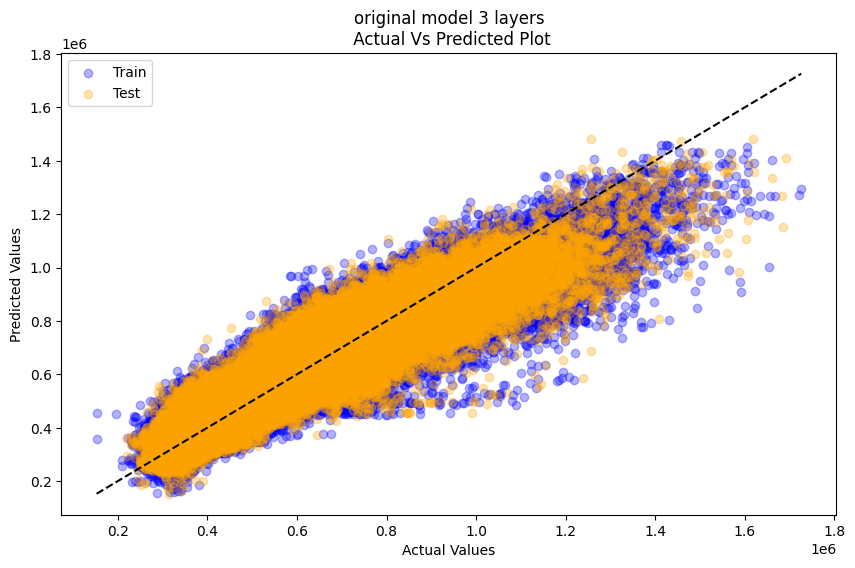

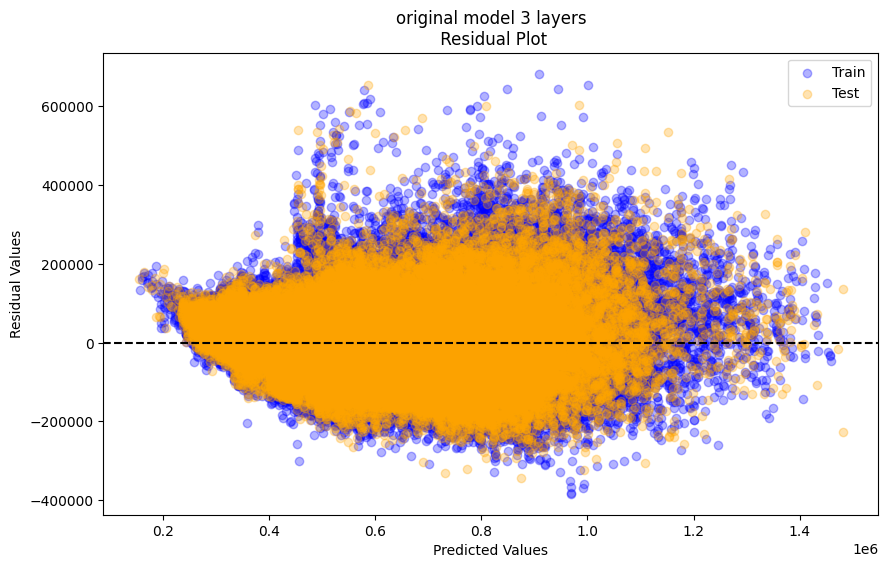

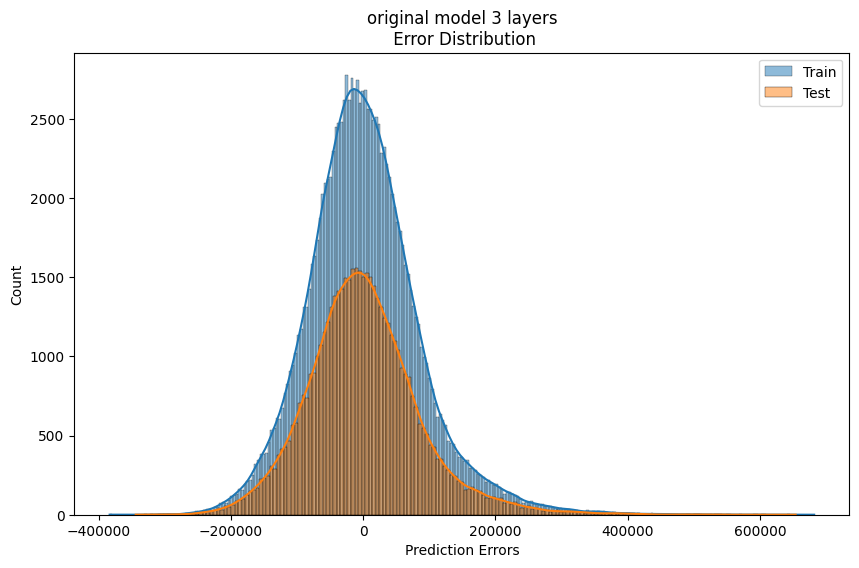

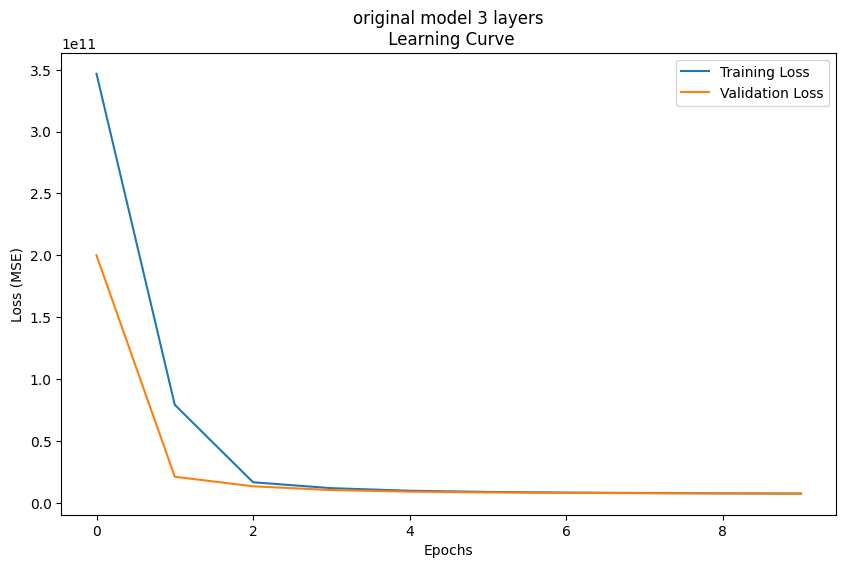

In [11]:
df_results,y_pred_train, y_pred_test = evaluate_model(model, X_train, y_train, X_test, y_test)
df_results.to_csv('./data/model_evaluation.csv')
print(df_results)

actual_predictions(y_train, y_pred_train, y_test, y_pred_test,'original model 3 layers\n')
### Residual Plot
residuals_train = y_train - y_pred_train.flatten()
residuals_test = y_test - y_pred_test.flatten()
residualplot(y_pred_train, y_pred_test, residuals_train, residuals_test, 'original model 3 layers\n')
error_distribution_plot(residuals_train,residuals_test,'original model 3 layers\n')
learning_curve_plot(history,'original model 3 layers\n')


## Test the model with different layers

In [12]:

def create_regression_model4(input_shape, params={}):
    name='4 layers'
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),    
        tf.keras.layers.Dense(32, activation='relu'),  
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model,name

def create_regression_model5(input_shape, params={}):
    name='5 layers'
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),    
        tf.keras.layers.Dense(32, activation='relu'),  
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model,name

def create_regression_model6(input_shape, params={}):
    name='6 layers'
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),    
        tf.keras.layers.Dense(32, activation='relu'),  
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model,name

def create_regression_model7(input_shape, params={}):
    name='7 layers'
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),    
        tf.keras.layers.Dense(32, activation='relu'),    
        tf.keras.layers.Dense(32, activation='relu'),  
        tf.keras.layers.Dense(16, activation='relu'),  
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model,name

def create_regression_model8(input_shape, params={}):
    name='8 layers'
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),    
        tf.keras.layers.Dense(32, activation='relu'),    
        tf.keras.layers.Dense(32, activation='relu'),  
        tf.keras.layers.Dense(16, activation='relu'), 
        tf.keras.layers.Dense(16, activation='relu'),  
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model,name

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 3s 750us/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step

Model: original 3 layers
Training time: 0:00:42
                                   Train      Test
Root Mean Squared Error         86143.01   85999.2
Mean Aboslute Error             64557.18  64390.54
Mean Aboslute Percentage Error      10.7     10.69
R2 score                            0.82      0.82


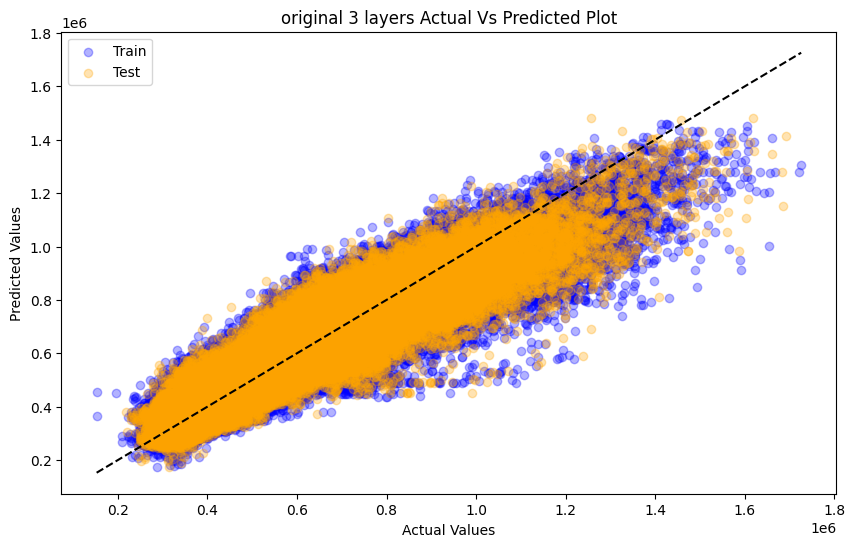

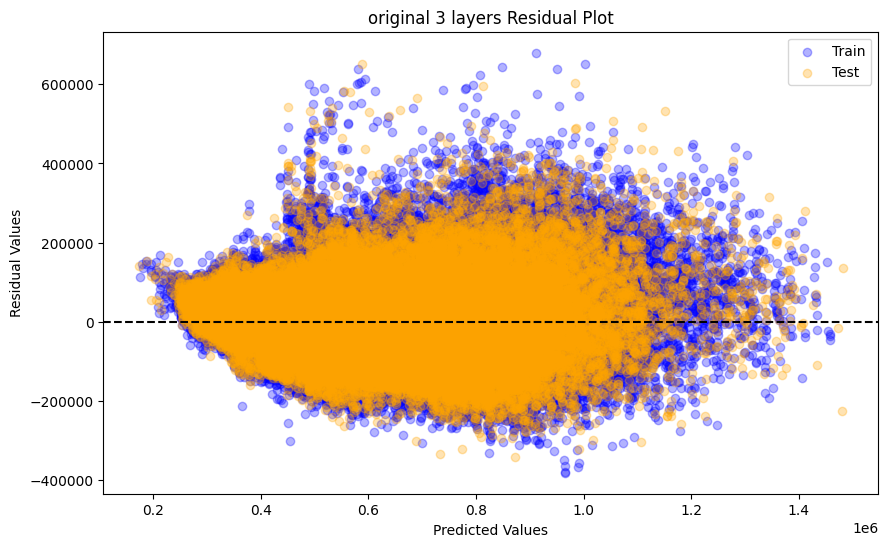

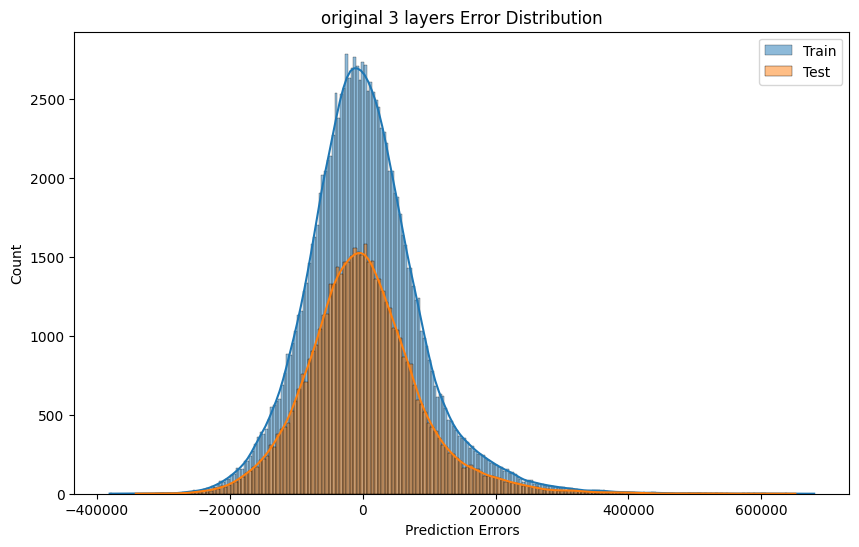

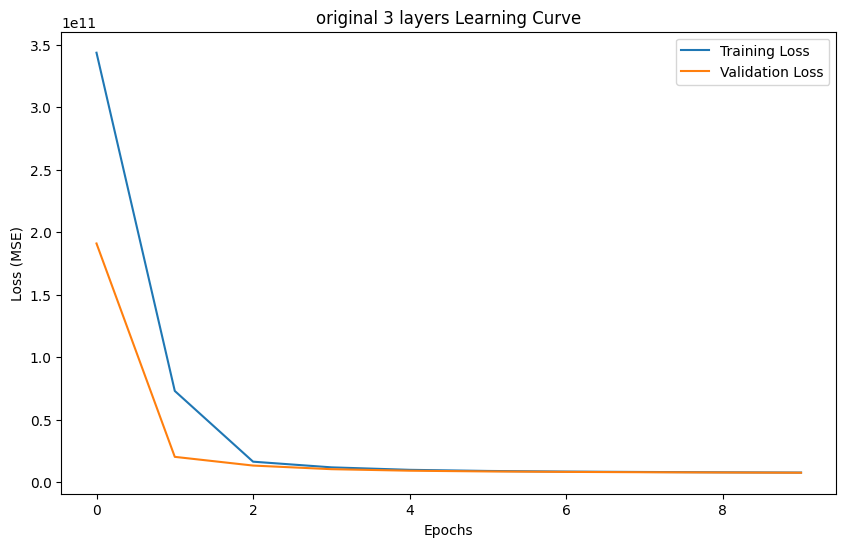

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 3s 708us/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step

Model: 4 layers
Training time: 0:00:49
                                   Train      Test
Root Mean Squared Error         68737.03  68608.75
Mean Aboslute Error             50381.96  50337.73
Mean Aboslute Percentage Error      8.24      8.25
R2 score                            0.88      0.88


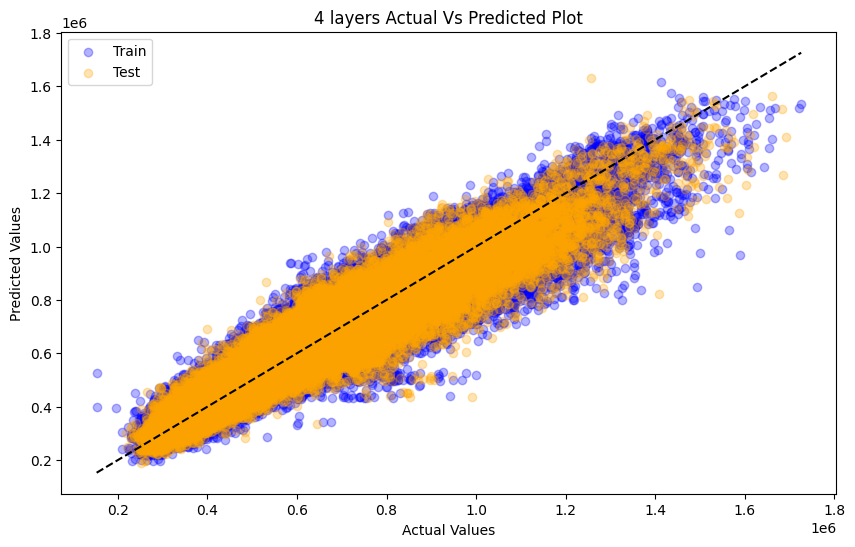

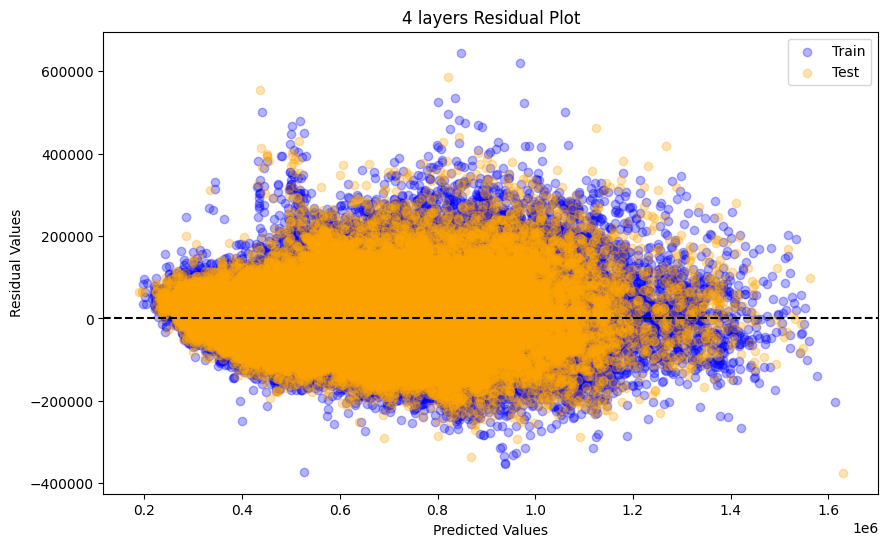

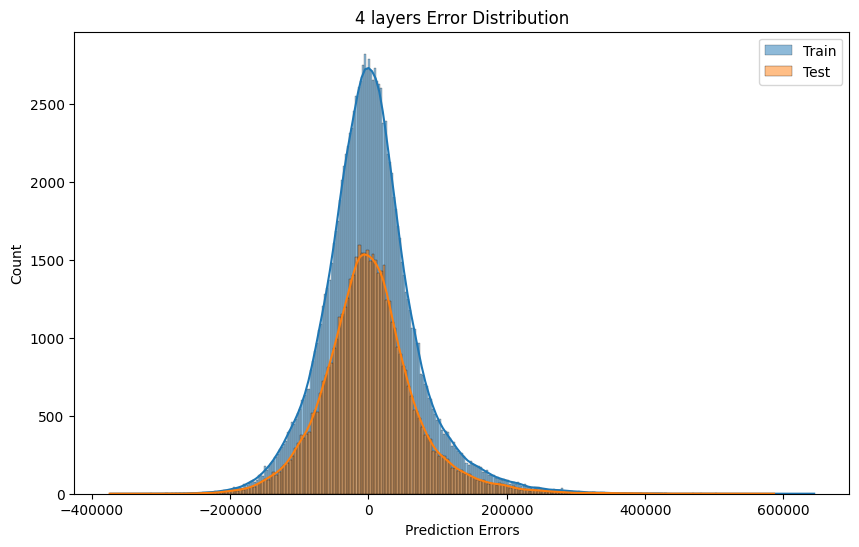

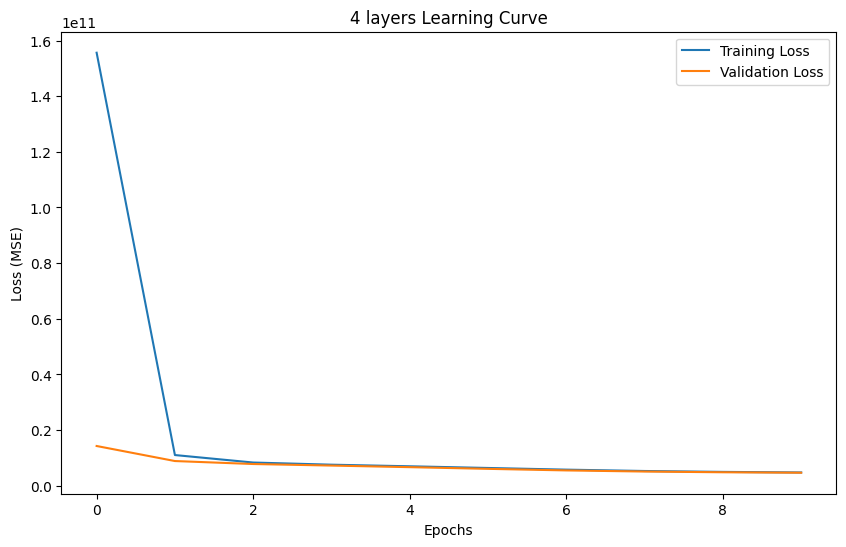

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 3s 832us/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step

Model: 5 layers
Training time: 0:00:50
                                   Train      Test
Root Mean Squared Error         64005.34  63810.09
Mean Aboslute Error             46280.87  46142.46
Mean Aboslute Percentage Error      7.49      7.48
R2 score                             0.9       0.9


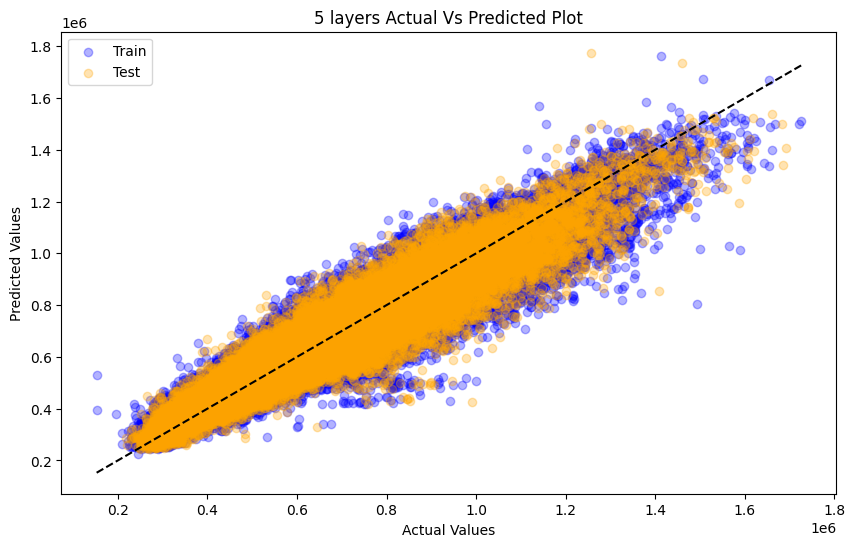

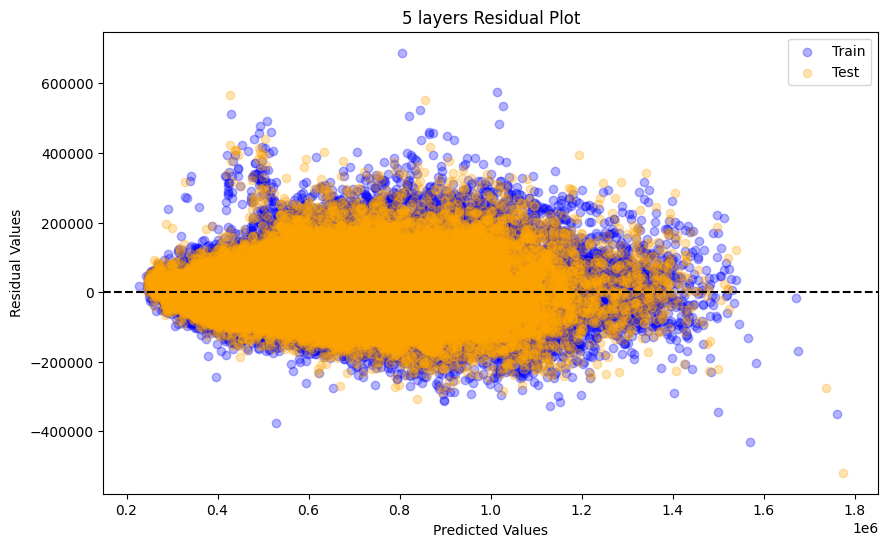

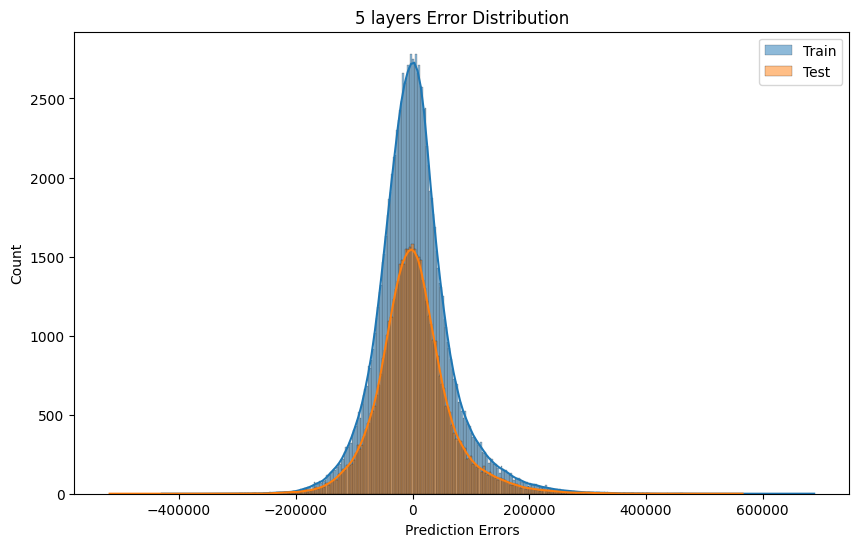

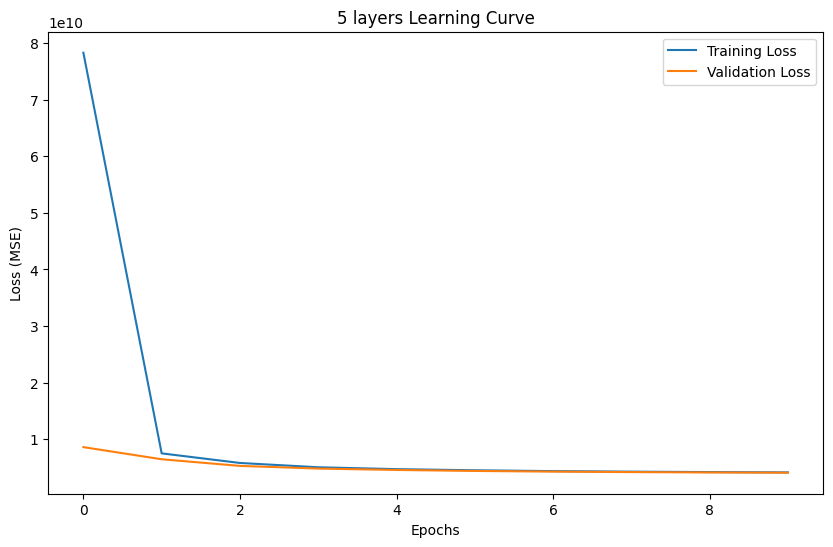

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 3s 799us/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step

Model: 6 layers
Training time: 0:00:54
                                   Train      Test
Root Mean Squared Error          63511.2  63323.53
Mean Aboslute Error             45871.38  45776.97
Mean Aboslute Percentage Error      7.42      7.41
R2 score                             0.9       0.9


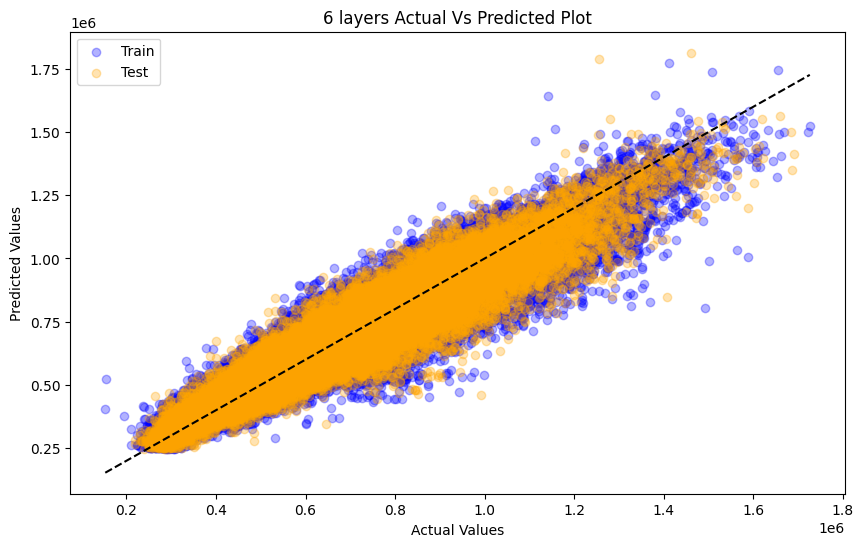

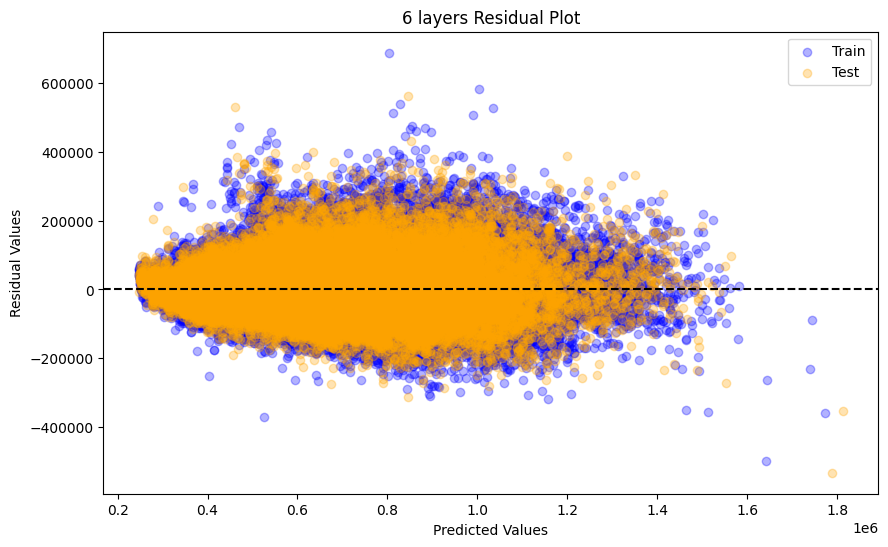

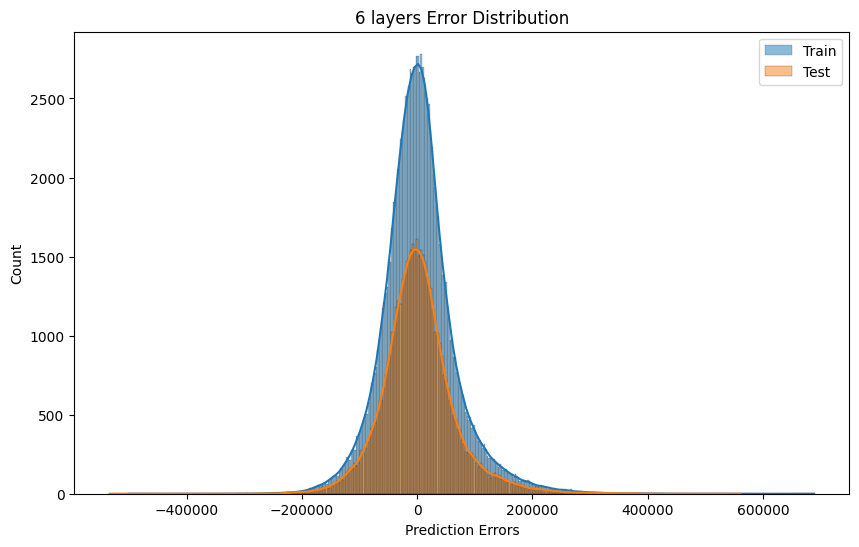

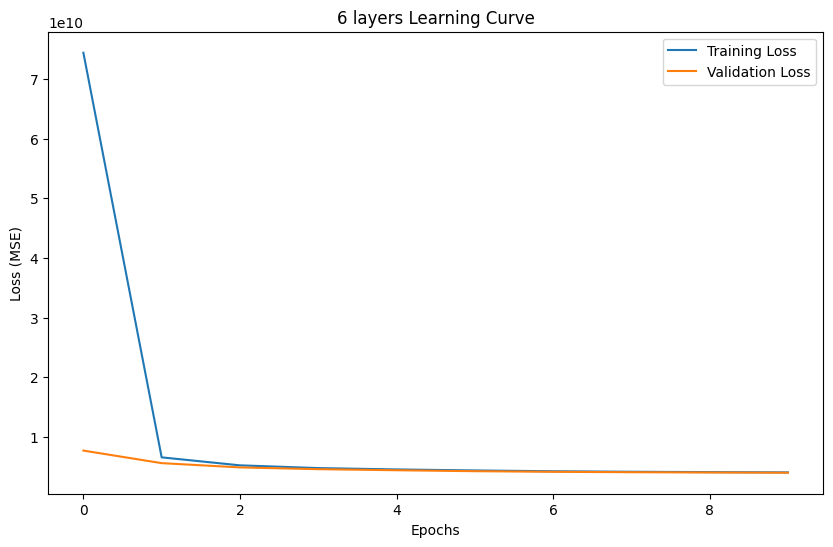

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 3s 850us/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 916us/step

Model: 7 layers
Training time: 0:01:00
                                   Train      Test
Root Mean Squared Error         62052.31  61844.95
Mean Aboslute Error             44568.14  44495.05
Mean Aboslute Percentage Error      7.21      7.22
R2 score                            0.91      0.91


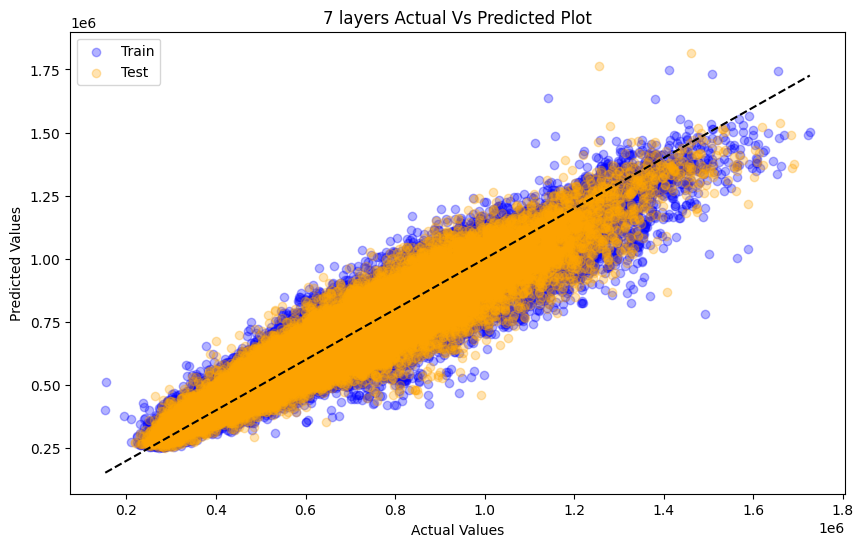

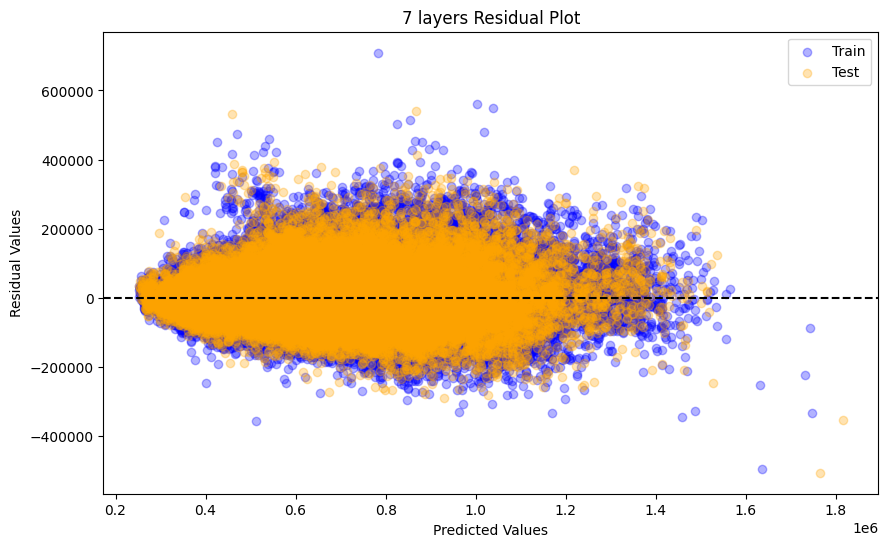

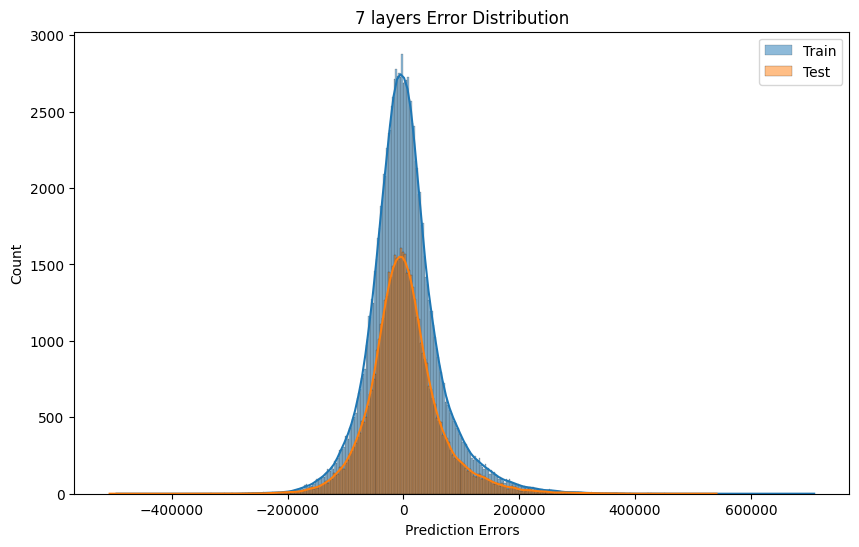

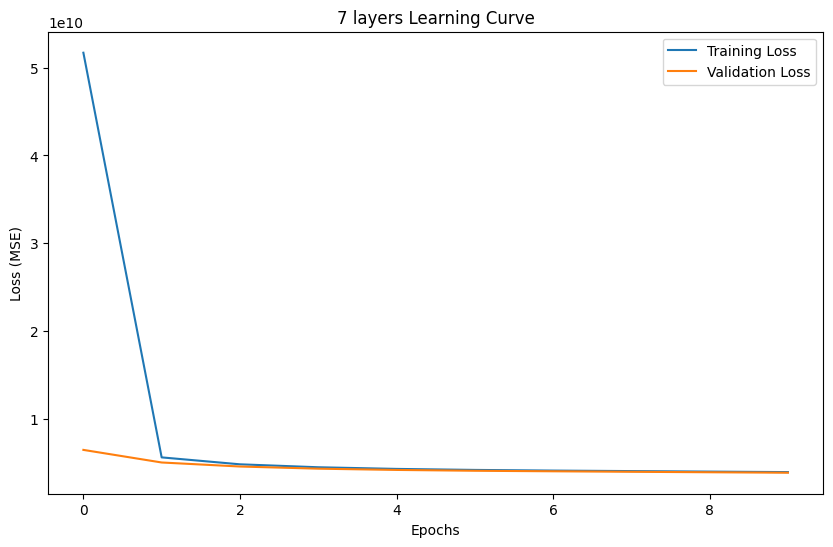

In [29]:

# List of all model creation functions
model_functions = [
    create_regression_model,
    create_regression_model4,
    create_regression_model5,
    create_regression_model6,
    create_regression_model7
    ]

# Dictionary to store all model info
info = {}

for model_func in model_functions:
    # Create model and get its name
    model, name = model_func(input_shape=[X_train.shape[1]])
    
    # Train the model and record time
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, 
                       validation_data=(X_test, y_test), verbose=0)
    end_time = time.time()
    training_time = str(timedelta(seconds=end_time-start_time)).split(".")[0]

    # Evaluate the model
    df_results, y_pred_train, y_pred_test = evaluate_model(model, X_train, y_train, X_test, y_test)
    # Calculate residuals
    residuals_train = y_train - y_pred_train.flatten()
    residuals_test = y_test - y_pred_test.flatten()
    
    # Store all information
    info[name] = {
        'model': model,
        'name': name,
        'training_time': training_time,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'df_results': df_results,
        'history': history,
        'residuals_train': residuals_train,
        'residuals_test': residuals_test
    }
    
    # Save results to CSV
    df_results.to_csv(f'./data/model_evaluation_{name}.csv')
    
    # Print results
    print(f"\nModel: {name}")
    print(f"Training time: {training_time}")
    print(df_results)
    
    # Generate plots
    actual_predictions(y_train, y_pred_train, y_test, y_pred_test, name)
    residualplot(y_pred_train, y_pred_test, residuals_train, residuals_test, name)
    error_distribution_plot(residuals_train, residuals_test, name)
    learning_curve_plot(history, name)

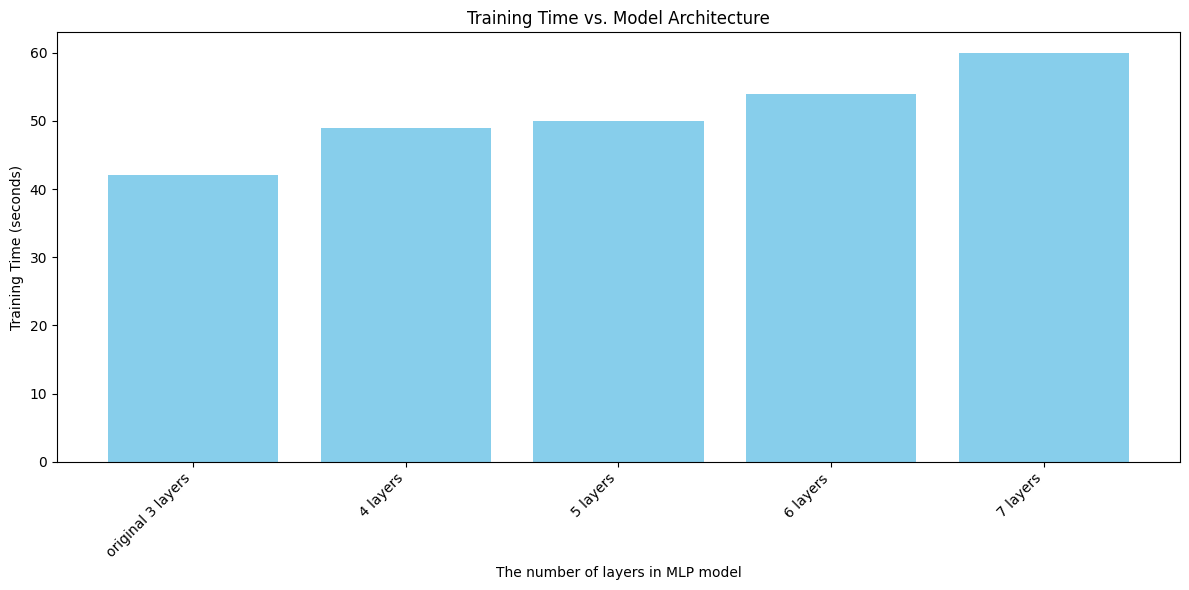

In [30]:

names = list(info.keys())
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

training_times = [info[name]['training_time'] for name in names]
times = [time_to_seconds(t) for t in training_times]
# Plot
plt.figure(figsize=(12, 6))
plt.bar(names, times, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("The number of layers in MLP model")
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs. Model Architecture')
plt.tight_layout()
plt.show()

done


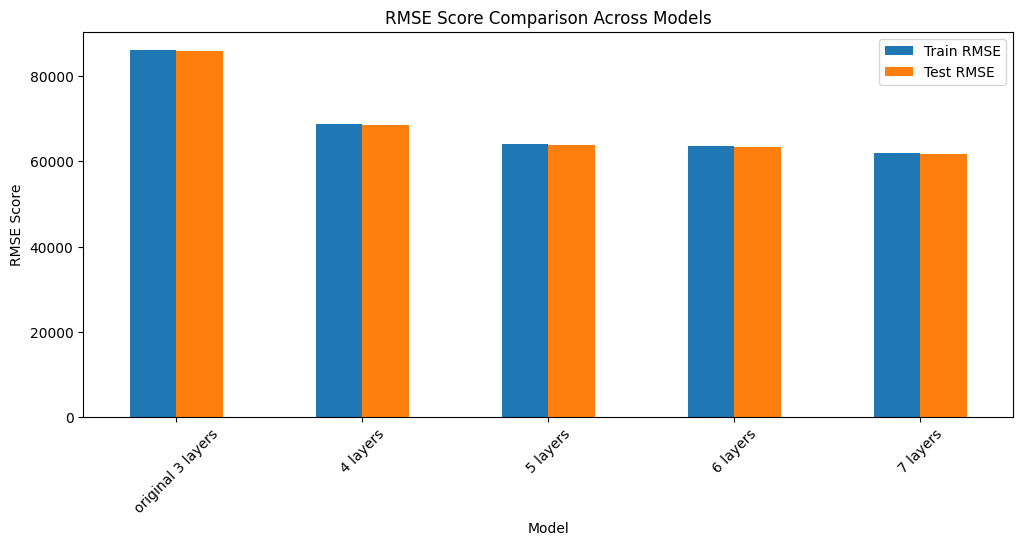

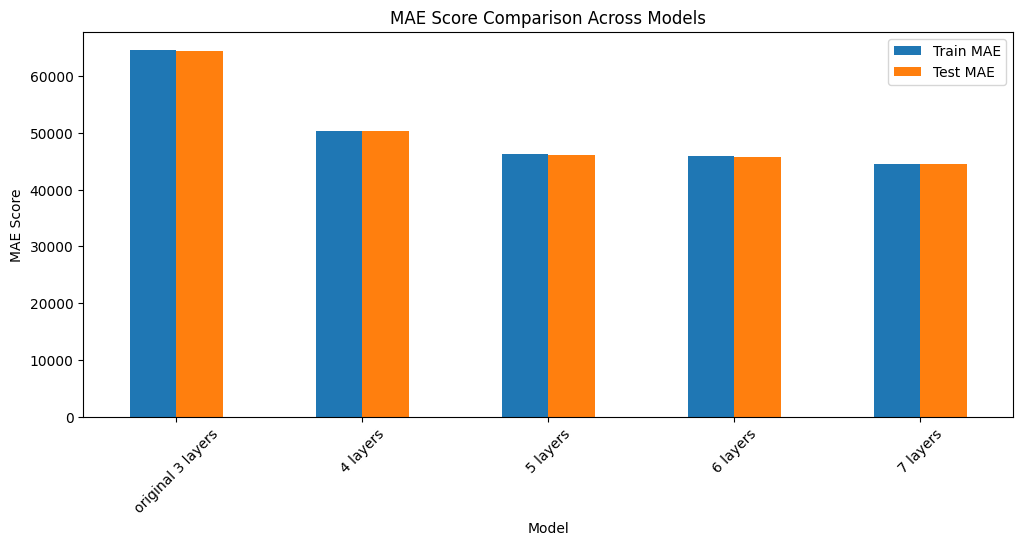

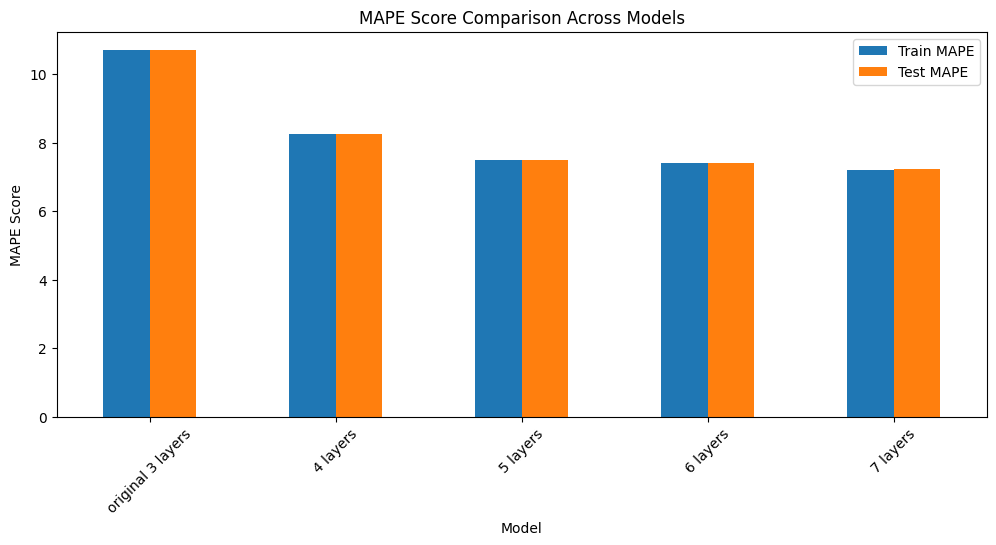

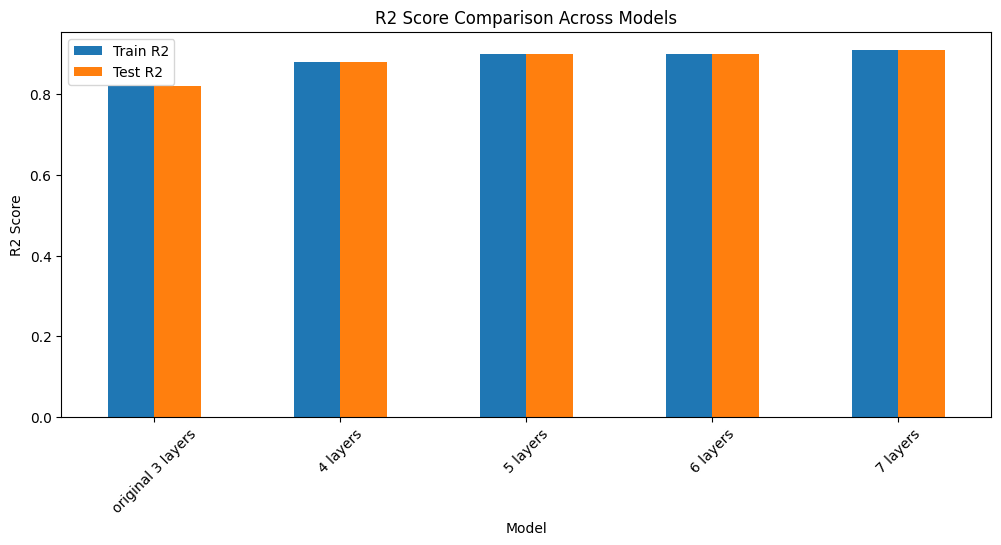

In [31]:

# Create a summary DataFrame
metrics = []
for name in info:
    metrics.append({
        'Model': name,
        'Train RMSE': info[name]['df_results'].loc['Root Mean Squared Error', 'Train'],
        'Test RMSE': info[name]['df_results'].loc['Root Mean Squared Error', 'Test'],
        'Train MAE': info[name]['df_results'].loc['Mean Aboslute Error', 'Train'],
        'Test MAE': info[name]['df_results'].loc['Mean Aboslute Error', 'Test'],
        'Train MAPE': info[name]['df_results'].loc['Mean Aboslute Percentage Error', 'Train'],
        'Test MAPE': info[name]['df_results'].loc['Mean Aboslute Percentage Error', 'Test'],
        'Train R2': info[name]['df_results'].loc['R2 score', 'Train'],
        'Test R2': info[name]['df_results'].loc['R2 score', 'Test']
    })
print('done')
df_metrics = pd.DataFrame(metrics)
plotlist = ['RMSE', 'MAE', "MAPE", "R2"]
# Plot the metric scores
for plotname in plotlist:
    df_metrics.set_index('Model')[[f'Train {plotname}', f'Test {plotname}']].plot(kind='bar', figsize=(12, 5))
    plt.title(f'{plotname} Score Comparison Across Models')
    plt.ylabel(f'{plotname} Score')
    plt.xticks(rotation=45)
    plt.show()

In [37]:
print(df_metrics.head())

               Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train MAPE  \
0  original 3 layers    86143.01   85999.20   64557.18  64390.54       10.70   
1           4 layers    68737.03   68608.75   50381.96  50337.73        8.24   
2           5 layers    64005.34   63810.09   46280.87  46142.46        7.49   
3           6 layers    63511.20   63323.53   45871.38  45776.97        7.42   
4           7 layers    62052.31   61844.95   44568.14  44495.05        7.21   

   Test MAPE  Train R2  Test R2  
0      10.69      0.82     0.82  
1       8.25      0.88     0.88  
2       7.48      0.90     0.90  
3       7.41      0.90     0.90  
4       7.22      0.91     0.91  


In [36]:
# Save as HTML
df_metrics.to_html("model_performance.html", float_format="%.2f", index=False, justify="center")


In [32]:
df_metrics

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE,Train MAPE,Test MAPE,Train R2,Test R2
0,original 3 layers,86143.01,85999.20,64557.18,64390.54,10.70,10.69,0.82,0.82
1,4 layers,68737.03,68608.75,50381.96,50337.73,8.24,8.25,0.88,0.88
2,5 layers,64005.34,63810.09,46280.87,46142.46,7.49,7.48,0.90,0.90
3,6 layers,63511.20,63323.53,45871.38,45776.97,7.42,7.41,0.90,0.90
4,7 layers,62052.31,61844.95,44568.14,44495.05,7.21,7.22,0.91,0.91
